In [33]:
import numpy as np
import pandas as pd
import xarray as xr
import xgboost as xgb
import seaborn as sns
import itertools as it
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
%run ../src/models/geo_helpers.py
%run ../src/models/section_series.py
%matplotlib inline
pd.options.display.float_format = '{:,.4f}'.format

In [2]:
city_locations_path = '../data/external/' +\
    'worldcitiespop.txt'

city_locations = pd.read_csv(city_locations_path, encoding = "ISO-8859-1").rename(columns={'City': 'city'})
city_locations = city_locations[city_locations['Population'] > 0] # filter for populated cities
print('Shape: {}'.format(city_locations.shape))
city_locations.head()

KeyboardInterrupt: 

In [3]:
earthquake_locations_path = '../data/external/' +\
    'earthquakes_affected_locations/earthquakes_affected_locations.csv'

earthquake_locations = pd.read_csv(earthquake_locations_path, encoding = "ISO-8859-1").drop('country', axis=1)
earthquake_locations['city'] = earthquake_locations['city'].apply(lambda c: c.lower())
print('Shape: {}'.format(earthquake_locations.shape))
earthquake_locations.head()

Shape: (2719, 12)


,id,city,latitude,longitude,geoname,year,month,day,Totaldeaths,Totalaffected,Totaldamage000US,insured_losses
0,1,takhar,36.7000,69.8000,NaN,1992,5,20,14,0,0,0
1,2,jowzan,36.7500,66.0000,Jowzjan,1994,5,1,160,100330,0,0
2,2,mazar-i-sharif,36.7500,67.0000,mazar-i-sharif,1994,5,1,160,100330,0,0
3,2,balkh,36.7501,66.8997,balkh,1994,5,1,160,100330,0,0
4,2,termez,37.2242,67.2783,NaN,1994,5,1,160,100330,0,0


In [4]:
%run ../src/models/section_series.py
annual_frames = {}
for year in range(1993, 2014):
    print('Loading data for year {}'.format(year))
    try:
        annual_frames[year] = pd.read_csv('../data/processed/section_series_returns_small/{}.csv'.format(year)).set_index('city')
    except FileNotFoundError:
        earthquake_locations_in_year = earthquake_locations[earthquake_locations.year == year]
        earthquake_cities_in_year = earthquake_locations_in_year['city'].unique()
        annual_frames[year] = pd.merge(city_locations, earthquake_locations_in_year, on='city', how='left')
        annual_frames[year] = annual_frames[year].fillna(0).reset_index().groupby('city').agg({
            'Totaldeaths': 'sum',
            'Totalaffected': 'sum',
            'Totaldamage000US': 'sum',
            'insured_losses': 'sum',
            'Latitude': 'first',
            'Longitude': 'first',
            'city': 'first'
        }).set_index('city').rename(columns={
            'Latitude': 'latitude',
            'Longitude': 'longitude',
            'Totaldeaths': 'total_deaths',
            'Totalaffected': 'total_affected',
            'Totaldamage000US': 'total_damage_usd'
        })
        annual_frames[year]['year'] = year
        annual_frames[year]['earthquake_dummy'] = annual_frames[year].index.map(lambda c: c in earthquake_cities_in_year)
        series_loader = SectionSeriesLoader(
            img_shape=(200, 200),
            start_year=year,
            end_year=year,
            SRC_PATH='../data/interim/Version_4_DMSP-OLS_Nighttime_Lights_Time_Returns/*.npz')
        target_coords_list = [{'lat': r[0],'lng': r[1]} for r
            in annual_frames[year][['latitude', 'longitude']].values]
        annual_frames[year]['mean_luminosity_return'] = series_loader.load_multiple_means(target_coords_list).reshape(-1)
        annual_frames[year].to_csv('../data/processed/section_series_returns_small/{}.csv'.format(year))
        
    print(annual_frames[year].shape)
    
panel = xr.Dataset.from_dataframe(pd.concat(annual_frames))
del annual_frames

Loading data for year 1993
(43183, 9)
Loading data for year 1994
(43183, 9)
Loading data for year 1995
(43183, 9)
Loading data for year 1996
(43183, 9)
Loading data for year 1997
(43183, 9)
Loading data for year 1998
(43183, 9)
Loading data for year 1999
(43183, 9)
Loading data for year 2000
(43183, 9)
Loading data for year 2001
(43183, 9)
Loading data for year 2002
(43183, 9)
Loading data for year 2003
(43183, 9)
Loading data for year 2004
(43183, 9)
Loading data for year 2005
(43183, 9)
Loading data for year 2006
(43183, 9)
Loading data for year 2007
(43183, 9)
Loading data for year 2008
(43183, 9)
Loading data for year 2009
(43183, 9)
Loading data for year 2010
(43183, 9)
Loading data for year 2011
(43183, 9)
Loading data for year 2012
(43183, 9)
Loading data for year 2013
(43183, 9)


In [5]:
panel

<xarray.Dataset>
Dimensions:                 (city: 43183, level_0: 21)
Coordinates:
  * level_0                 (level_0) int64 1993 1994 1995 1996 1997 1998 ...
  * city                    (city) object '0' 'a' 'a coruna' ...
Data variables:
    insured_losses          (level_0, city) float64 0.0 0.0 0.0 0.0 0.0 0.0 ...
    total_affected          (level_0, city) float64 0.0 0.0 0.0 0.0 0.0 0.0 ...
    longitude               (level_0, city) float64 100.7 10.22 -8.407 ...
    latitude                (level_0, city) float64 18.79 63.97 43.37 39.15 ...
    total_damage_usd        (level_0, city) float64 0.0 0.0 0.0 0.0 0.0 0.0 ...
    total_deaths            (level_0, city) float64 0.0 0.0 0.0 0.0 0.0 0.0 ...
    year                    (level_0, city) int64 1993 1993 1993 1993 1993 ...
    earthquake_dummy        (level_0, city) bool False False False False ...
    mean_luminosity_return  (level_0, city) float64 -0.1373 0.6671 -0.4299 ...

In [6]:
%%time
try:
    data = pd.read_csv('../data/processed/section_series_returns_small/all.csv').set_index('city')
except FileNotFoundError:
    feature_cols = ['latitude', 'longitude', 'mean_luminosity_return', 'total_affected', 'total_damage_usd', 'insured_losses',
                    'total_deaths', 'earthquake_dummy']
    data = pd.melt(
        panel.to_dataframe()[feature_cols].reset_index(),
        id_vars=['city','level_0'],
        value_vars=feature_cols)\
        .rename(columns={'level_0': 'year'})
    data = data\
        .set_index(data[['year','variable']].astype(str).apply(lambda r: '_'.join(r), axis=1))\
        .drop(['year','variable'], axis=1)
    data = data.groupby(['city']).apply(lambda g: g.transpose().loc['value',:])
    data.to_csv('../data/processed/section_series_returns_small/all.csv')

data.head()

CPU times: user 1.9 s, sys: 163 ms, total: 2.06 s
Wall time: 2.25 s


In [7]:
targets = data[['2013_mean_luminosity_return']].fillna(0)
features = data.drop(['2013_mean_luminosity_return'], axis=1)

In [43]:
def cross_validate(features, targets, params, n_splits=2):
    k_fold = KFold(n_splits=n_splits, shuffle=True, random_state=23)
    param_names = list(params.keys())
    result = pd.DataFrame(columns=['mse','wmse','mae','wmae','r2','wr2','ev','wev'] + param_names)
    for train, test in k_fold.split(features, targets):
        train_data = xgb.DMatrix(data=features.iloc[train].values,
                                 label=targets.iloc[train].values,
                                 feature_names=features.columns)
        linear_tree_booster = xgb.train(
            params={
                'booster': 'gbtree',
                'objective': 'reg:linear',
                **params
            },
            dtrain=train_data,
            num_boost_round=25
        )
        pred = np.nan_to_num(linear_tree_booster.predict(test_data))
        result = result.append(pd.DataFrame({
            'mse': mean_squared_error(test_data.get_label(), pred),
            'wmse': mean_squared_error(test_data.get_label(), pred, sample_weight=test_data.get_label()),
            'mae': mean_absolute_error(test_data.get_label(), pred),
            'wmae': mean_absolute_error(test_data.get_label(), pred, sample_weight=test_data.get_label()),
            'r2': r2_score(test_data.get_label(), pred),
            'wr2': r2_score(test_data.get_label(), pred, sample_weight=test_data.get_label()),
            'ev': explained_variance_score(test_data.get_label(), pred),
            'wev': explained_variance_score(test_data.get_label(), pred, sample_weight=test_data.get_label()),
            **params
        }, index=[str(params)])) 
        
    return result.mean()


param_grid = {
    'n_estimators': [100],
    'eta': [.20],
    'max_depth': [26],
#     'alpha': [.3, .5, .7],
#     'booster': ['gblinear']
}
param_list = [dict(zip(param_grid, v)) for v in it.product(*param_grid.values())]
try:
    cv_results
except NameError:
    cv_results = pd.DataFrame(columns=['mse','wmse','mae','wmae','r2','wr2','ev','wev'] + list(param_grid.keys()))
    
for params in param_list:
    cv_results = cv_results.append(cross_validate(features, targets, params), ignore_index=True)
    
cv_results.groupby(list(param_grid.keys())).mean().sort_values('wmse')

mse    wmse    mae   wmae          r2  \
eta    max_depth n_estimators                                                
0.2000 24.0000   100.0000         0.0181  0.0066 0.0640 0.0625      0.9811   
       28.0000   100.0000         0.0181  0.0077 0.0640 0.0631      0.9811   
       26.0000   100.0000         0.0180  0.0078 0.0640 0.0637      0.9812   
0.1800 24.0000   100.0000         0.0183  0.0082 0.0648 0.0657      0.9809   
0.2500 24.0000   100.0000         0.0185  0.0092 0.0648 0.0647      0.9807   
0.1500 24.0000   100.0000         0.0190  0.0097 0.0685 0.0732      0.9801   
0.1300 24.0000   100.0000         0.0204  0.0125 0.0740 0.0851      0.9787   
0.8000 24.0000   100.0000         0.0345  0.0309 0.0920 0.1063      0.9640   
0.1000 24.0000   100.0000         0.0276  0.0351 0.0961 0.1336      0.9712   
0.0500 24.0000   100.0000         0.1030  0.3179 0.2216 0.4058      0.8925   
0.0300 24.0000   100.0000         0.2419  0.8527 0.3479 0.6650      0.7475   
0.0200 24.0000   100.0000         0.3797  1.3923 0.4388 0.8507      0.6036   
0.0100 24.0000   100.0000         0.6020  2.2659 0.5549 1.0875      0.3715   
0.0050 24.0000   100.0000         0.7601  2.8890 0.6244 1.2293      0.2065   
0.2000 24.0000   100.0000     1,040.1356 31.4838 0.3193 0.2591 -1,083.6063   

                                  wr2          ev     wev  booster  
eta    max_depth n_estimators                                       
0.2000 24.0000   100.0000      1.0095      0.9811  1.0026      nan  
       28.0000   100.0000      1.0111      0.9811  1.0042      nan  
       26.0000   100.0000      1.0113      0.9812  1.0043      nan  
0.1800 24.0000   100.0000      1.0118      0.9809  1.0031      nan  
0.2500 24.0000   100.0000      1.0132      0.9807  1.0082      nan  
0.1500 24.0000   100.0000      1.0140      0.9801  0.9987      nan  
0.1300 24.0000   100.0000      1.0180      0.9787  0.9922      nan  
0.8000 24.0000   100.0000      1.0443      0.9640  1.0408      nan  
0.1000 24.0000   100.0000      1.0505      0.9712  0.9775      nan  
0.0500 24.0000   100.0000      1.4613      0.8928  0.8544      nan  
0.0300 24.0000   100.0000      2.2358      0.7483  0.6906      nan  
0.0200 24.0000   100.0000      3.0171      0.6048  0.5462      nan  
0.0100 24.0000   100.0000      4.2820      0.3734  0.3272      nan  
0.0050 24.0000   100.0000      5.1842      0.2089  0.1793      nan  
0.2000 24.0000   100.0000     50.9421 -1,083.5378 50.6940      nan

In [13]:
train_data = xgb.DMatrix(data=features[::2].values,
                         label=targets[::2].values,
                         feature_names=features.columns)
test_data = xgb.DMatrix(data=features[1::2].values,
                        label=targets[1::2].values,
                        feature_names=features.columns)
linear_tree_booster = xgb.train(
    params={
        'booster': 'gbtree',
        'objective': 'reg:linear',
        'eta': 0.2,
        'max_depth': 24
    },
    dtrain=train_data,
    num_boost_round=25
)
pred = np.nan_to_num(linear_tree_booster.predict(test_data))
result = pd.DataFrame({
    'mse': mean_squared_error(test_data.get_label(), pred),
    'wmse': mean_squared_error(test_data.get_label(), pred, sample_weight=test_data.get_label()),
    'mae': mean_absolute_error(test_data.get_label(), pred),
    'wmae': mean_absolute_error(test_data.get_label(), pred, sample_weight=test_data.get_label()),
    'r2': r2_score(test_data.get_label(), pred),
    'wr2': r2_score(test_data.get_label(), pred, sample_weight=test_data.get_label()),
    'ev': explained_variance_score(test_data.get_label(), pred),
    'wev': explained_variance_score(test_data.get_label(), pred, sample_weight=test_data.get_label()),
}, index=['w'])

result

,ev,mae,mse,r2,wev,wmae,wmse,wr2
w,0.9775,0.0666,0.0213,0.9775,1.0023,0.0661,0.0089,1.0106


In [22]:
features[[c for c in features.columns if 'earthquake' in c]].sum()

1993_earthquake_dummy    12
1994_earthquake_dummy    14
1995_earthquake_dummy    38
1996_earthquake_dummy    17
1997_earthquake_dummy    11
1998_earthquake_dummy    30
1999_earthquake_dummy    26
2000_earthquake_dummy    20
2001_earthquake_dummy    43
2002_earthquake_dummy    25
2003_earthquake_dummy    36
2004_earthquake_dummy    53
2005_earthquake_dummy    30
2006_earthquake_dummy    21
2007_earthquake_dummy    28
2008_earthquake_dummy    18
2009_earthquake_dummy    44
2010_earthquake_dummy    22
2011_earthquake_dummy    32
2012_earthquake_dummy    44
2013_earthquake_dummy    26
dtype: int64

In [23]:
pred = linear_tree_booster.predict(test_data)
test_ae = test_data.get_label() - pred
test_wae = (test_data.get_label() - pred) * test_data.get_label()
test_mse = mean_squared_error(test_data.get_label(), pred)
true_mean = test_data.get_label().mean()

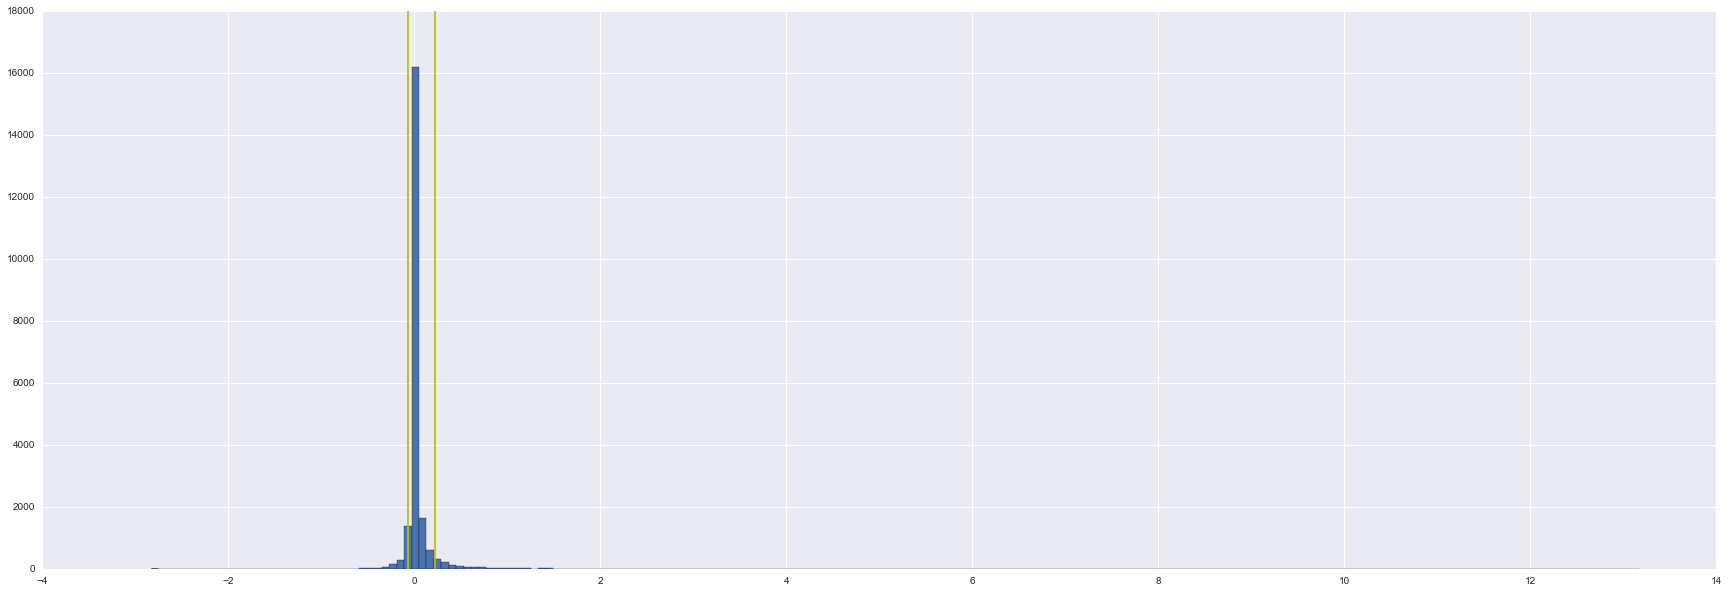

In [24]:
plt.figure(figsize=(30,10))
plt.hist(test_wae, bins=200)
plt.axvline(x=np.percentile(test_wae, 95), c='y')
plt.axvline(x=np.percentile(test_wae, 5), c='y')
plt.show()

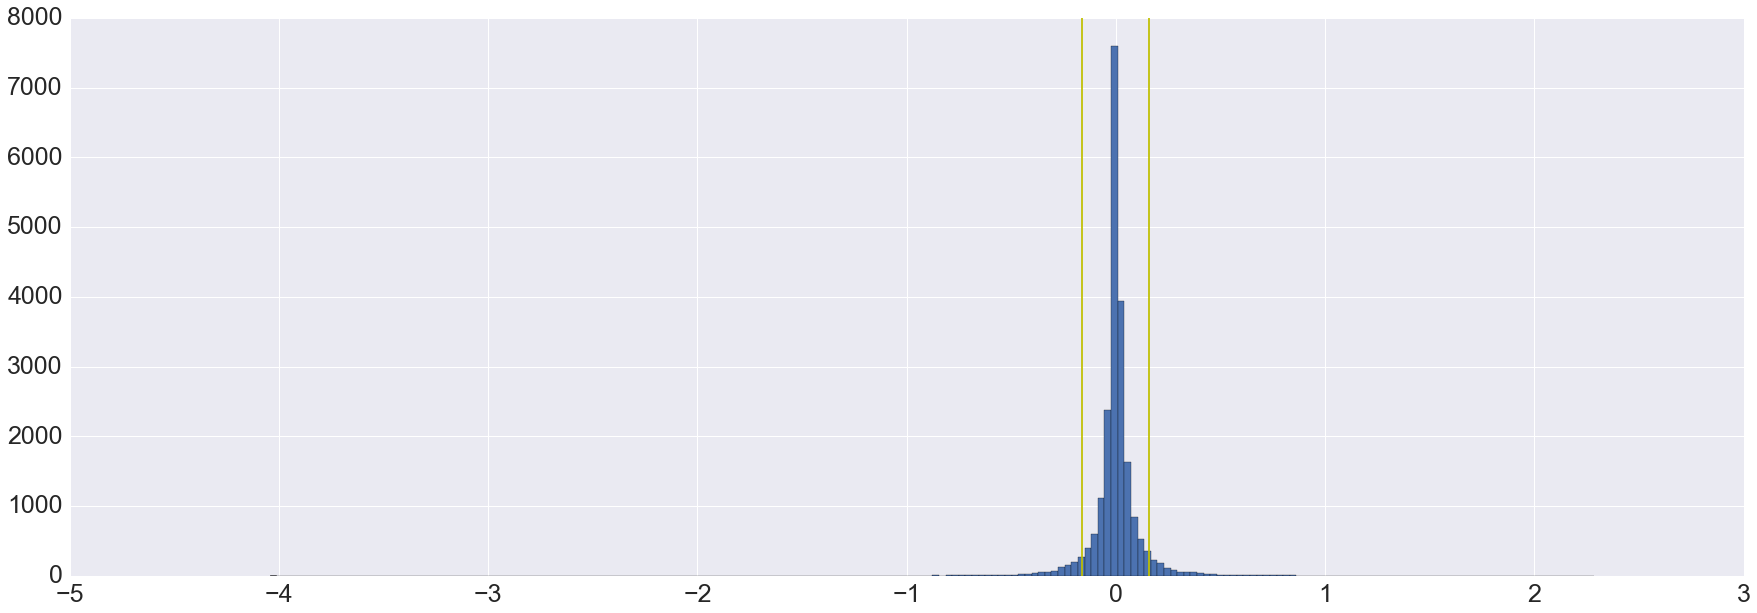

In [37]:
plt.figure(figsize=(30,10))
plt.hist(test_ae, bins=200)
plt.axvline(x=np.percentile(test_ae, 95), c='y')
plt.axvline(x=np.percentile(test_ae, 5), c='y')
plt.show()

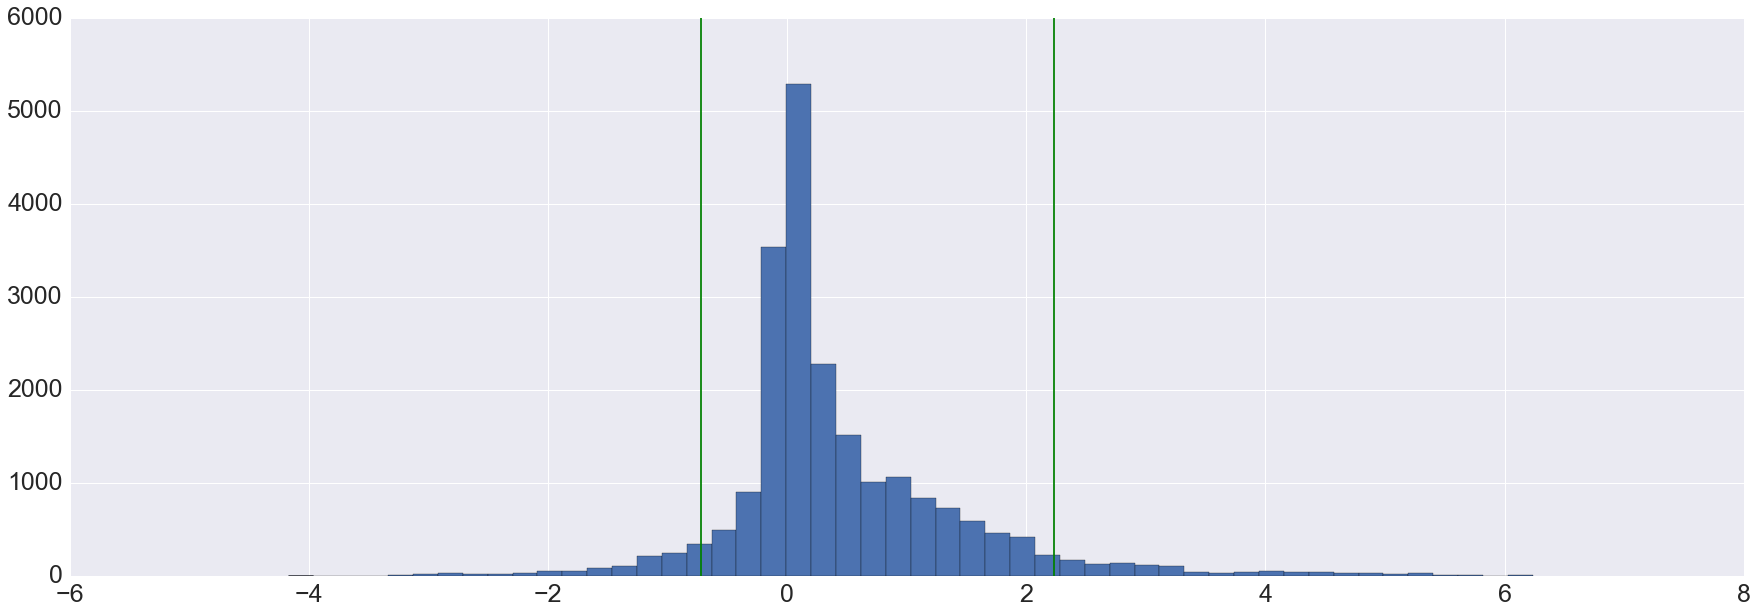

In [38]:
plt.figure(figsize=(30,10))
plt.hist(test_data.get_label(), bins=50)
plt.axvline(x=np.percentile(test_data.get_label(), 95), c='g')
plt.axvline(x=np.percentile(test_data.get_label(), 5), c='g')
plt.show()

In [30]:
linear_

Help on function plot_importance in module xgboost.plotting:

plot_importance(booster, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance', xlabel='F score', ylabel='Features', importance_type='weight', grid=True, **kwargs)
    Plot importance based on fitted trees.
    
    Parameters
    ----------
    booster : Booster, XGBModel or dict
        Booster or XGBModel instance, or dict taken by Booster.get_fscore()
    ax : matplotlib Axes, default None
        Target axes instance. If None, new figure and axes will be created.
    importance_type : str, default "weight"
        How the importance is calculated: either "weight", "gain", or "cover"
        "weight" is the number of times a feature appears in a tree
        "gain" is the average gain of splits which use the feature
        "cover" is the average coverage of splits which use the feature
            where coverage is defined as the number of samples affected by the split
    height : float, default 0.2
   

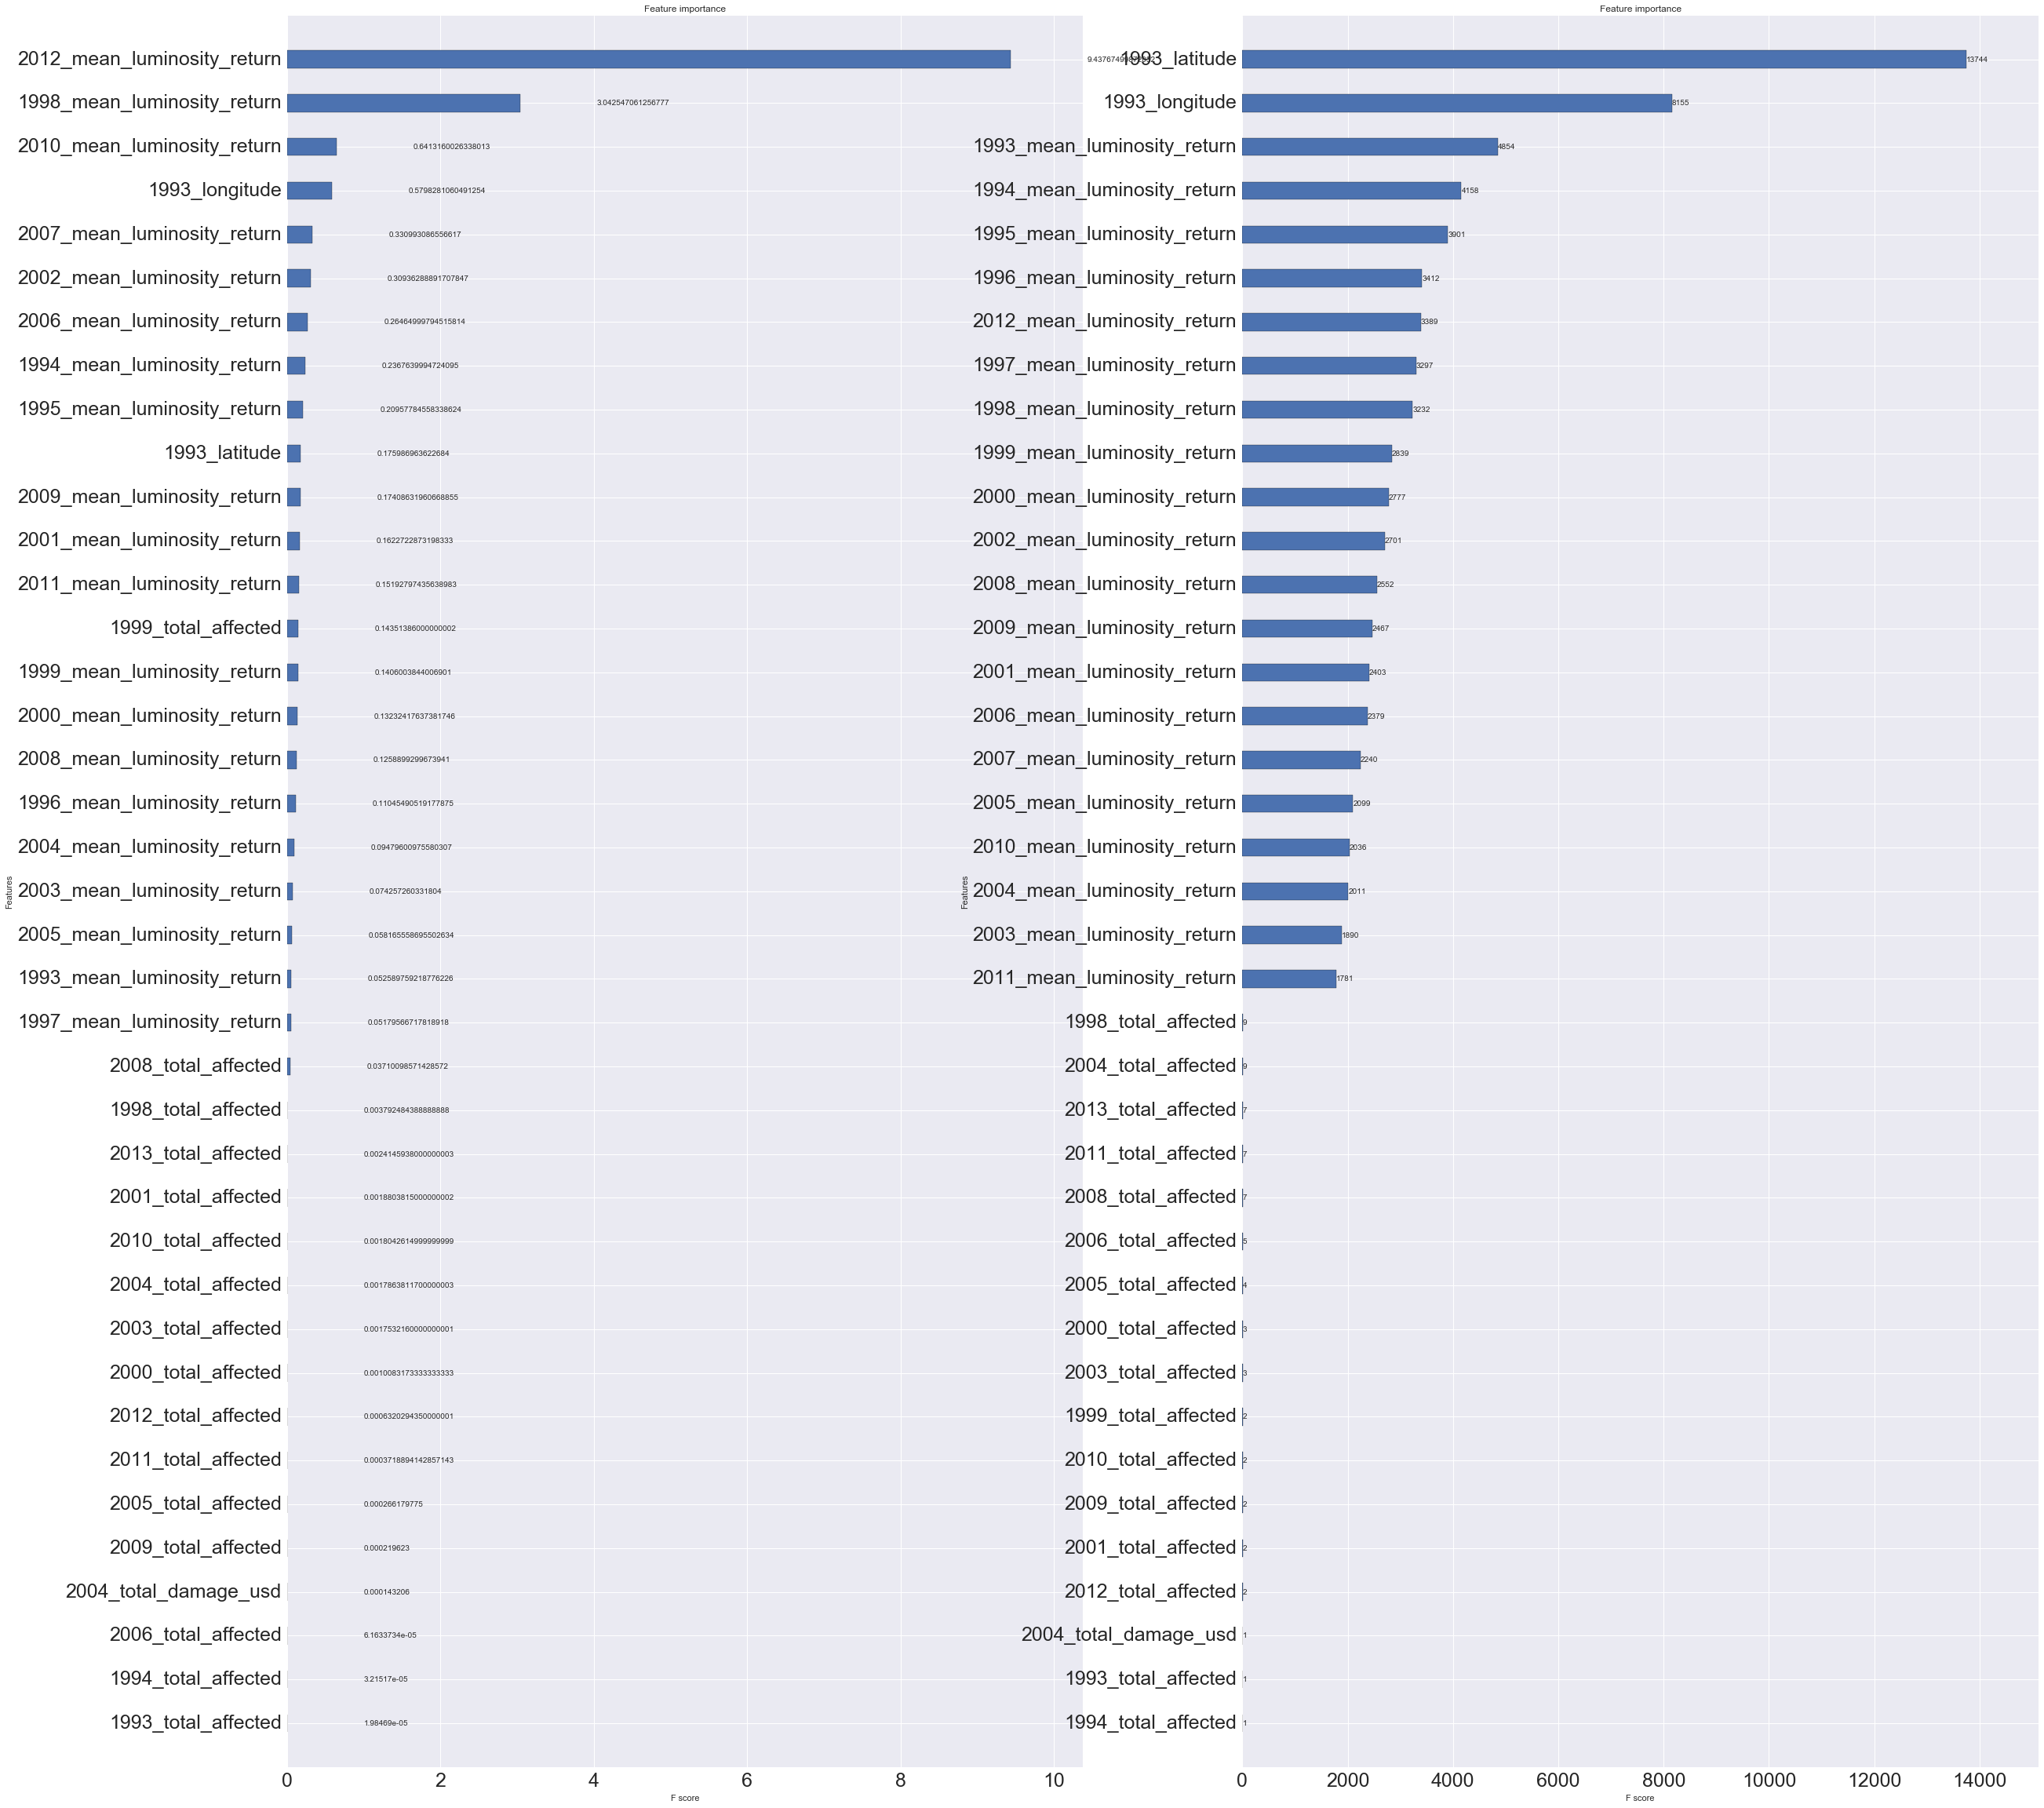

In [36]:
mpl.rc('xtick', labelsize=25) 
mpl.rc('ytick', labelsize=25) 
fig, axs = plt.subplots(1,2,figsize=(40,40))
xgb.plot_importance(linear_tree_booster, height=.4, importance_type='gain', ax=axs[0])
xgb.plot_importance(linear_tree_booster, height=.4, importance_type='weight', ax=axs[1])
plt.show()

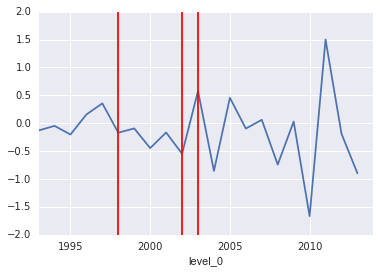

In [316]:
df = panel.sel(city='takhar').to_dataframe()
df['mean_luminosity_return'].plot()
for i, row in df[df['earthquake_dummy'] == True].iterrows():
    plt.axvline(x=row.year, c='r')

In [406]:
city_df = panel.sel(city='takhar')\
    .to_dataframe()[['latitude',
                     'longitude',
                     'mean_luminosity_return',
                     'total_affected',
                     'total_damage_usd',
                     'insured_losses',
                     'total_deaths',
                     'earthquake_dummy']].reset_index()
feature = city_df[(city_df.level_0 <= 2012) & (city_df.level_0 > 1994)].drop('level_0', axis=1).values.reshape(-1)
target = city_df[city_df.level_0 == 2013]['mean_luminosity_return'].mean()
# print('True: {}, Predicted: {}'.format(target,linear_tree_booster.predict(xgb.DMatrix(feature.reshape(1,-1)))))

In [409]:
city_df

,level_0,latitude,longitude,mean_luminosity_return,total_affected,total_damage_usd,insured_losses,total_deaths,earthquake_dummy
0,1993,47.56,124.22,-0.13,0.00,0.00,0.00,0.00,False
1,1994,47.56,124.22,-0.05,0.00,0.00,0.00,0.00,False
2,1995,47.56,124.22,-0.20,0.00,0.00,0.00,0.00,False
3,1996,47.56,124.22,0.16,0.00,0.00,0.00,0.00,False
4,1997,47.56,124.22,0.36,0.00,0.00,0.00,0.00,False
5,1998,47.56,124.22,-0.17,"32,818.00","10,000.00",0.00,"2,323.00",True
6,1999,47.56,124.22,-0.09,0.00,0.00,0.00,0.00,False
7,2000,47.56,124.22,-0.45,0.00,0.00,0.00,0.00,False
8,2001,47.56,124.22,-0.17,0.00,0.00,0.00,0.00,False
9,2002,47.56,124.22,-0.55,"3,513.00",0.00,0.00,150.00,True
